$$
T_{\text{id}}(t+1) = T_{\infty}(t) + \left(T_{\text{id}}(t) - T_{\infty}(t)\right) e^{-\Delta t / \tau} - e^{-\left(\alpha_1 \cdot (\text{Tid} - \text{Tcon}) + \alpha_2 \cdot \text{Frun} + \alpha_0\right)}
$$


In [7]:
import pandas as pd
import os

def extract_all_target_reaching_segments(df, auto_id, output_folder='segments_dynamic', tol=0.5):
    df = df[df['Auto Id'] == auto_id].copy()
    df = df.sort_values('DateTime').reset_index(drop=True)

    df['Frun_prev'] = df['Frun'].shift(1)
    df['Frun_change'] = (df['Frun_prev'] == 0) & (df['Frun'] == 1)
    change_points = df[df['Frun_change']].index.tolist()

    if not change_points:
        print("에어컨이 켜지는 구간이 없습니다.")
        return

    os.makedirs(output_folder, exist_ok=True)
    segment_count = 0

    for start_idx in change_points:
        end_idx = None

        for idx in range(start_idx + 1, len(df)):
            Tcon_current = df.loc[idx, 'Tcon']
            Tid_current = df.loc[idx, 'Tid']
            if abs(Tid_current - Tcon_current) <= tol:
                end_idx = idx
                break

        if end_idx is not None:
            segment_df = df.iloc[start_idx:end_idx + 1][['DateTime', 'Frun', 'Tcon', 'Tid', 'Tod', 'Hid', 'Hod', 'Power']].copy()

            start_time = df.loc[start_idx, 'DateTime']
            end_time = df.loc[end_idx, 'DateTime']
            file_name = f"segment_{start_time.strftime('%Y-%m-%d_%H-%M')}_to_{end_time.strftime('%Y-%m-%d_%H-%M')}.csv"
            file_path = os.path.join(output_folder, file_name)

            segment_df.to_csv(file_path, index=False)
            segment_count += 1
            print(f"[INFO] 저장됨: {file_path}")

    if segment_count == 0:
        print("목표 온도에 도달한 구간이 없습니다.")


In [4]:
import pandas as pd
import os
from datetime import datetime

def load_and_concatenate_csv(folder_path):
    all_data = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            try:
                df = pd.read_csv(file_path)
                df.columns = df.columns.str.strip()  # 공백 제거

                # 열 이름 체크
                if 'Auto Id' not in df.columns:
                    raise ValueError(f"[오류] {file}에 'AutoId' 열이 없습니다.")

                if 'Time' not in df.columns:
                    raise ValueError(f"[오류] {file}에 'Time' 열이 없습니다.")

                # 날짜 추출
                date_str = ''.join(filter(str.isdigit, file))[:8]
                date_base = pd.to_datetime(date_str, format='%Y%m%d')

                # DateTime 생성
                df['Time'] = df['Time'].astype(str).str.strip()
                df['DateTime'] = pd.to_datetime(date_base.strftime('%Y-%m-%d') + ' ' + df['Time'], errors='coerce')

                # 유효한 DateTime만 유지
                df = df[df['DateTime'].notna()].copy()
                all_data.append(df)
            except Exception as e:
                print(f"파일 무시됨: {file}, 오류: {e}")
    if not all_data:
        raise RuntimeError("유효한 데이터를 가진 CSV 파일이 없습니다.")
    return pd.concat(all_data, ignore_index=True)

In [8]:
if __name__ == "__main__":
    folder_path = '/home/deok/Desktop/LOG_SMART_202407'  # CSV 폴더 경로
    auto_id = 2

    all_data = load_and_concatenate_csv(folder_path)
    extract_all_target_reaching_segments(all_data, auto_id, output_folder='target_segments_auto2')

파일 무시됨: LOG_SMARTCARE_20240704.csv, 오류: Error tokenizing data. C error: Expected 73 fields in line 70310, saw 119

[INFO] 저장됨: target_segments_auto2/segment_2024-07-05_08-22_to_2024-07-05_08-46.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-05_22-50_to_2024-07-05_23-04.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-07_15-40_to_2024-07-07_21-06.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-07_17-50_to_2024-07-07_21-06.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-12_16-39_to_2024-07-13_00-56.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-13_00-38_to_2024-07-13_00-56.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-18_09-13_to_2024-07-18_09-16.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-20_21-43_to_2024-07-20_22-08.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-21_14-28_to_2024-07-21_15-53.csv
[INFO] 저장됨: target_segments_auto2/segment_2024-07-28_11-47_to_2024-07-28_15-16.csv


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# -------------------------
# 1. 하이퍼파라미터
# -------------------------
tau = 7806.44  # seconds
dt = 5        # 30초 샘플링 간격
exp_decay = np.exp(-dt / tau)

# -------------------------
# 2. 회귀 학습용 함수
# -------------------------
def load_all_segments(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in files:
        df = pd.read_csv(os.path.join(folder_path, file))
        if all(col in df.columns for col in ['Tid', 'Tcon', 'Frun', 'Tod']):
            dfs.append(df)
    return dfs

def extract_regression_dataset(dfs):
    U_list, Y_list = [], []

    for df in dfs:
        df = df[['Tid', 'Tcon', 'Frun', 'Tod']].copy()
        df = df.dropna().reset_index(drop=True)

        df['T_inf'] = 0.351 * df['Tod'] + 17.612

        for t in range(len(df) - 1):
            Tid_t = df.loc[t, 'Tid']
            Tid_tp1 = df.loc[t + 1, 'Tid']
            Tinf_t = df.loc[t, 'T_inf']
            Tcon_t = df.loc[t, 'Tcon']
            Frun_t = df.loc[t, 'Frun']

            # 비제어 예측값
            Tid_pred_no_ac = Tinf_t + (Tid_t - Tinf_t) * exp_decay

            # 냉방 효과로 인한 감소량
            delta_T_ac = Tid_pred_no_ac - Tid_tp1

            # 음수 또는 NaN인 경우 회귀 불가 → 제외
            if delta_T_ac <= 0 or np.isnan(delta_T_ac):
                continue

            u1 = max(0, Tid_t - Tcon_t)
            u2 = Frun_t
            u3 = 1  # bias term
            U_list.append([u1, u2, u3])
            Y_list.append(np.log(delta_T_ac + 1e-6))  # 로그 안정성 보장

    return np.array(U_list), np.array(Y_list)

def train_regression_model(U, Y):
    reg = LinearRegression()
    reg.fit(U, Y)

    # 예측 및 RMSE 계산
    Y_pred = reg.predict(U)
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))

    print(f"[INFO] 회귀 계수: {reg.coef_}")
    print(f"[INFO] 절편 (alpha_0): {reg.intercept_}")
    print(f"[INFO] RMSE (log domain): {rmse:.4f}")
    return reg


In [40]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# -------------------------
# 1. 하이퍼파라미터
# -------------------------
tau = 7806.44  # seconds
dt = 5         # 5초 샘플링 간격
exp_decay = np.exp(-dt / tau)

# -------------------------
# 2. 회귀 학습용 함수
# -------------------------
def load_all_segments(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in files:
        df = pd.read_csv(os.path.join(folder_path, file))
        if all(col in df.columns for col in ['Tid', 'Tcon', 'Frun', 'Tod']):
            dfs.append(df)
    return dfs

def extract_regression_dataset(dfs):
    U_list, Y_list = [], []

    for df in dfs:
        df = df[['Tid', 'Tcon', 'Frun', 'Tod']].copy()
        df = df.dropna().reset_index(drop=True)
        df['T_inf'] = 0.351 * df['Tod'] + 17.612

        for t in range(len(df) - 1):
            Tid_t = df.loc[t, 'Tid']
            Tid_tp1 = df.loc[t + 1, 'Tid']
            Tinf_t = df.loc[t, 'T_inf']
            Tcon_t = df.loc[t, 'Tcon']
            Frun_t = df.loc[t, 'Frun']

            # 비제어 예측값
            Tid_pred_no_ac = Tinf_t + (Tid_t - Tinf_t) * exp_decay

            # 냉방 효과로 인한 감소량
            delta_T_ac = Tid_pred_no_ac - Tid_tp1

            # 음수 또는 NaN인 경우 회귀 불가 → 제외
            if delta_T_ac <= 0 or np.isnan(delta_T_ac):
                continue

            u1 = max(0, Tid_t - Tcon_t)
            u2 = Frun_t
            u3 = 1  # bias term
            U_list.append([u1, u2, u3])
            Y_list.append(delta_T_ac)  # 로그 대신 실제 ΔT_ac 값

    return np.array(U_list), np.array(Y_list)

def train_regression_model(U, Y):
    # 로그 변환된 값을 학습 데이터로 사용
    log_Y = np.log(Y + 1e-6)  # 안정성 확보
    reg = LinearRegression()
    reg.fit(U, log_Y)

    # 로그 스케일에서 예측
    log_Y_pred = reg.predict(U)

    # 로그 복원
    Y_pred = np.exp(log_Y_pred)

    # **원래 단위에서 RMSE 계산**
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))

    print(f"[INFO] 회귀 계수: {reg.coef_}")
    print(f"[INFO] 절편 (alpha_0): {reg.intercept_}")
    print(f"[INFO] RMSE (original ΔT_ac domain): {rmse:.4f}")
    return reg


In [41]:
folder_path = '/home/deok/Desktop/LG_exp/target_segments_auto2'  # 세그먼트 폴더
dfs = load_all_segments(folder_path)

U, Y = extract_regression_dataset(dfs)
model = train_regression_model(U, Y)

# -------------------------
# 4. 결과 출력
# -------------------------
print("회귀 결과:")
print(f"alpha_1 = {model.coef_[0]:.4f}")
print(f"alpha_2 = {model.coef_[1]:.4f}")
print(f"alpha_0 = {model.coef_[2] + model.intercept_:.4f}")  # bias 포함

# model.predict(U) 등을 통해 예측값 사용 가능

[INFO] 회귀 계수: [0.33142589 0.         0.        ]
[INFO] 절편 (alpha_0): -7.204135759916911
[INFO] RMSE (original ΔT_ac domain): 0.0809
회귀 결과:
alpha_1 = 0.3314
alpha_2 = 0.0000
alpha_0 = -7.2041


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_rc_model(csv_path, alpha_0, alpha_1, alpha_2, tau=7806.44):
    df = pd.read_csv(csv_path, parse_dates=['DateTime'])
    df = df.sort_values('DateTime').reset_index(drop=True)

    df['t_sec'] = (df['DateTime'] - df['DateTime'].iloc[0]).dt.total_seconds()
    df['dt'] = df['t_sec'].diff().fillna(5)  # 기본 30초

    df['T_inf'] = 0.351 * df['Tod'] + 17.612

    # ✅ 최초 시작 온도는 실제 Tid(0)
    T_pred = [df.loc[0, 'Tid']]

    for i in range(1, len(df)):
        #T_prev = df.loc[i-1, 'Tid']                  # 바로 전 시점의 예측값
        T_prev = T_pred[-1]
        T_inf = df.loc[i - 1, 'T_inf']
        dt = df.loc[i, 'dt']
        Tcon = df.loc[i - 1, 'Tcon']
        Frun = df.loc[i - 1, 'Frun']

        # ✅ 제어 효과 계산 (예측값 기반)
        control_input =  np.exp((alpha_1 * max(0, T_prev - Tcon) + alpha_2 * Frun + alpha_0))
        #control_effect = np.clip(np.exp(-control_input), 0.001, 1)

        decay = np.exp(-dt / tau)

        # ✅ RC 모델에 따라 다음 예측 온도 계산
        T_next = T_inf + (T_prev - T_inf) * decay - (control_input)
        T_pred.append(T_next)

    df['Tid_pred'] = T_pred
    return df



def plot_simulation_result(df):
    plt.figure(figsize=(12, 5))
    plt.plot(df['DateTime'], df['Tid'], label='Actual Tid', color='blue')
    plt.plot(df['DateTime'], df['Tid_pred'], label='Predicted Tid (RC Model)', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Indoor Temperature (°C)')
    plt.title('RC Model Simulation vs Actual')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


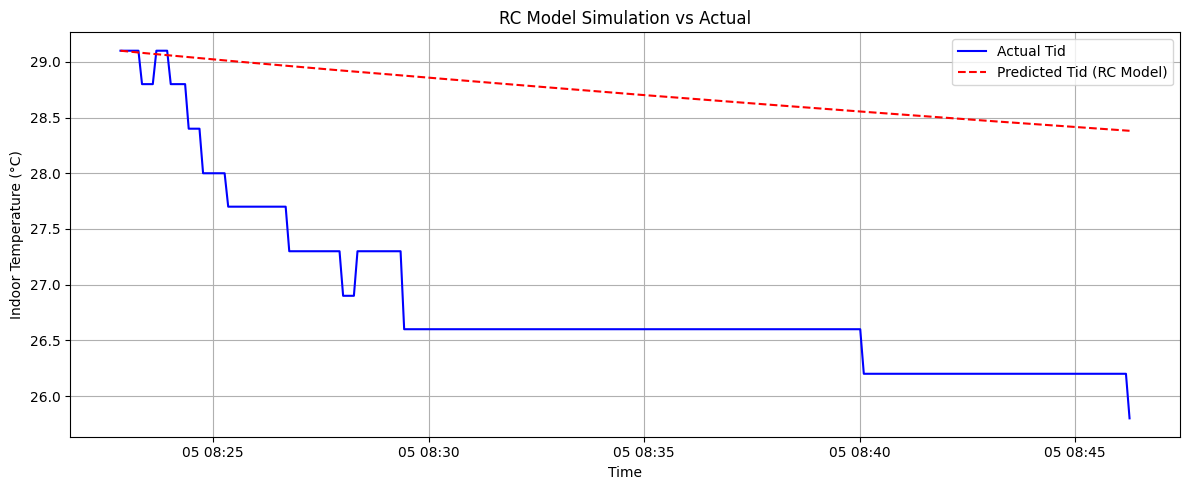

In [39]:
# CSV 파일 경로를 여기에 입력하세요:
csv_path = "/home/deok/Desktop/LG_exp/target_segments_auto2/segment_2024-07-05_08-22_to_2024-07-05_08-46.csv"  # 예시

# 회귀 결과로 얻은 계수 입력
alpha_1 = 0.3314
alpha_2 = 0.0000
alpha_0 = -7.2041

# 시뮬레이션 수행
df_simulated = simulate_rc_model(csv_path, alpha_0, alpha_1, alpha_2)

# 결과 시각화
plot_simulation_result(df_simulated)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -------------------------
# 1. 하이퍼파라미터
# -------------------------
tau = 7806.44  # seconds
dt = 5         # 5초 샘플링 간격

# -------------------------
# 2. 회귀 학습용 함수
# -------------------------
def load_all_segments(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in files:
        df = pd.read_csv(os.path.join(folder_path, file), parse_dates=['DateTime'])
        if all(col in df.columns for col in ['Tid', 'Tcon', 'Frun', 'Tod']):
            dfs.append(df)
    return dfs

def extract_regression_dataset(dfs):
    U_list, Y_list = [], []

    for df in dfs:
        df = df[['DateTime', 'Tid', 'Tcon', 'Frun', 'Tod']].copy()
        df = df.dropna().reset_index(drop=True)

        # 시간(sec)과 외기온도 기반 T_inf 계산
        df['t_sec'] = (df['DateTime'] - df['DateTime'].iloc[0]).dt.total_seconds()
        df['T_inf'] = 0.351 * df['Tod'] + 17.612

        # 초기값 (에어컨이 없는 경우의 시작온도)
        T0 = df['Tid'].iloc[0]

        # **비제어 RC 모델로 예측 곡선**
        df['Tid_pred_no_ac'] = df['T_inf'] + (T0 - df['T_inf']) * np.exp(-df['t_sec'] / tau)

        # ΔT_ac = (비제어 예측) - (실제)
        df['Delta_T_ac'] = df['Tid_pred_no_ac'] - df['Tid']
        df['Delta_T_ac_2'] = -df['Delta_T_ac'] + T0
        
        # 제어 입력 u 벡터와 ΔT_ac 수집
        for t in range(len(df) - 1):
            delta_T = df.loc[t + 1, 'Delta_T_ac_2']  # 다음 스텝에서의 냉방 효과
            if delta_T <= 0 or np.isnan(delta_T):
                continue

            u1 = df.loc[t, 'Tid'] - df.loc[t, 'Tcon']
            u2 = df.loc[t, 'Frun']
            u3 = 1  # bias term
            U_list.append([u1, u2, u3])
            Y_list.append(delta_T)

    return np.array(U_list), np.array(Y_list)

def train_regression_model(U, Y, plot=True):
    # 로그 변환 후 학습: log(ΔT_ac) = -(α1 u1 + α2 u2 + α0)
    log_Y = np.log(Y + 1e-6)  # 안정성 확보
    reg = LinearRegression()
    reg.fit(U, log_Y)

    log_Y_pred = reg.predict(U)
    Y_pred = np.exp(log_Y_pred)

    rmse = np.sqrt(mean_squared_error(Y, Y_pred))

    print(f"[INFO] 회귀 계수 (alpha_1, alpha_2, bias): {reg.coef_}")
    print(f"[INFO] 절편 (alpha_0): {reg.intercept_}")
    print(f"[INFO] RMSE (ΔT_ac domain): {rmse:.4f}")

    # -------------------------
    # 예측 결과 플롯
    # -------------------------
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(Y, label='Actual ΔT_ac', color='blue')
        plt.plot(Y_pred, label='Predicted ΔT_ac', color='red', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('ΔT_ac (°C)')
        plt.title('Actual vs Predicted ΔT_ac')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 산점도
        plt.figure(figsize=(6, 6))
        plt.scatter(Y, Y_pred, alpha=0.5, color='purple')
        plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)  # y=x 참조선
        plt.xlabel('Actual ΔT_ac')
        plt.ylabel('Predicted ΔT_ac')
        plt.title('Scatter: Actual vs Predicted ΔT_ac')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return reg


[INFO] 회귀 계수 (alpha_1, alpha_2, bias): [0.03244775 0.         0.        ]
[INFO] 절편 (alpha_0): 3.2487836467707107
[INFO] RMSE (ΔT_ac domain): 0.0934


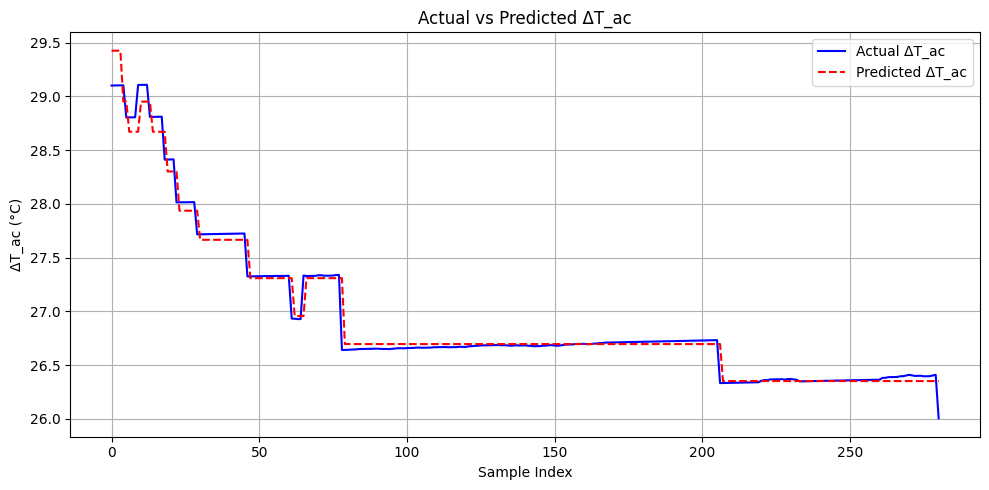

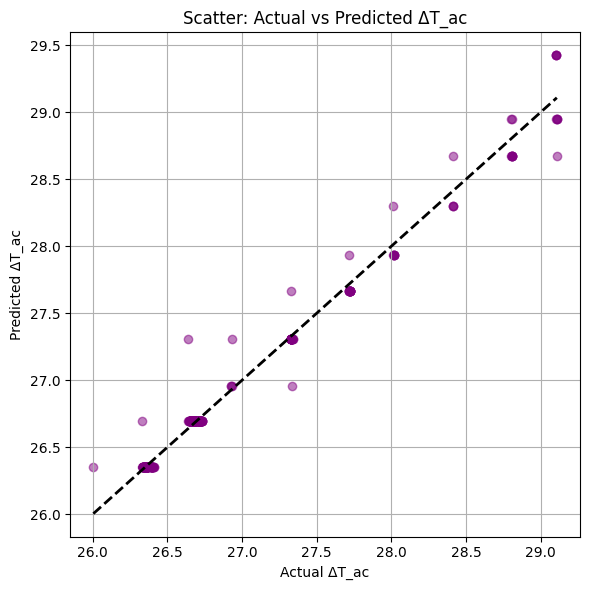

회귀 결과:
alpha_1 = 0.0324
alpha_2 = 0.0000
alpha_0 = 3.2488


In [320]:
folder_path = '/home/deok/Desktop/LG_exp/target_segments_auto2'  # 세그먼트 폴더
dfs = load_all_segments(folder_path)

U, Y = extract_regression_dataset(dfs)
model = train_regression_model(U, Y, plot=True)

# -------------------------
# 4. 결과 출력
# -------------------------
print("회귀 결과:")
print(f"alpha_1 = {model.coef_[0]:.4f}")
print(f"alpha_2 = {model.coef_[1]:.4f}")
print(f"alpha_0 = {model.coef_[2] + model.intercept_:.4f}")  # bias 포함


In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_rc_model(csv_path, alpha_0, alpha_1, alpha_2, tau=7806.44):
    # CSV 로드 및 시간 정렬
    df = pd.read_csv(csv_path, parse_dates=['DateTime'])
    df = df.sort_values('DateTime').reset_index(drop=True)

    # 시간 및 외기온도 기반 T_inf 계산
    df['t_sec'] = (df['DateTime'] - df['DateTime'].iloc[0]).dt.total_seconds()
    df['dt'] = df['t_sec'].diff().fillna(5)  # 첫 샘플은 기본 5초로 설정
    df['T_inf'] = 0.351 * df['Tod'] + 17.612

    # 비제어 RC 모델 (에어컨이 꺼졌을 때의 온도)
    T0 = df.loc[0, 'Tid']  # 초기 실내온도
    df['Tid_pred_no_ac'] = df['T_inf'] + (T0 - df['T_inf']) * np.exp(-df['t_sec'] / tau)

    # 제어 효과를 추가 반영한 온도 예측
    T_pred = [T0] # 리컬시브 예측 시뮬로 하고 싶으면 활성화 (예측도 개선 필요)
    
    for i in range(1, len(df)):
        Tid = df.loc[i -1, 'Tid'] #실제 오도기반ㅇ으로 시뮬로 하고 싶으면 활성화
        T_prev = T_pred[-1]
        T_inf = df.loc[i - 1, 'T_inf']
        dt = df.loc[i, 'dt']
        Tcon = df.loc[i - 1, 'Tcon']
        Frun = df.loc[i - 1, 'Frun']
        T_no_ac = df['Tid_pred_no_ac'].iloc[i]  

        # 제어 효과 계산 (냉방 효과를 -exp(...)로 모델링)
        control_input = alpha_1 * (T_prev - Tcon) + alpha_2 * Frun + alpha_0
        control_effect = np.exp(control_input)  # 양수 값으로 변환

        # RC + 제어 효과
        T_next = control_effect
        T_pred.append(T_next)

    df['Tid_pred'] = T_pred
    return df

def plot_simulation_result(df):
    plt.figure(figsize=(12, 5))
    plt.plot(df['DateTime'], df['Tid'], label='Actual Tid', color='blue')
    #plt.plot(df['DateTime'], df['Tid_pred_no_ac'], label='Predicted (No AC)', color='green', linestyle=':')
    plt.plot(df['DateTime'], df['Tid_pred'], label='Predicted Tid (RC + Control)', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Indoor Temperature (°C)')
    plt.title('RC Model Simulation vs Actual')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

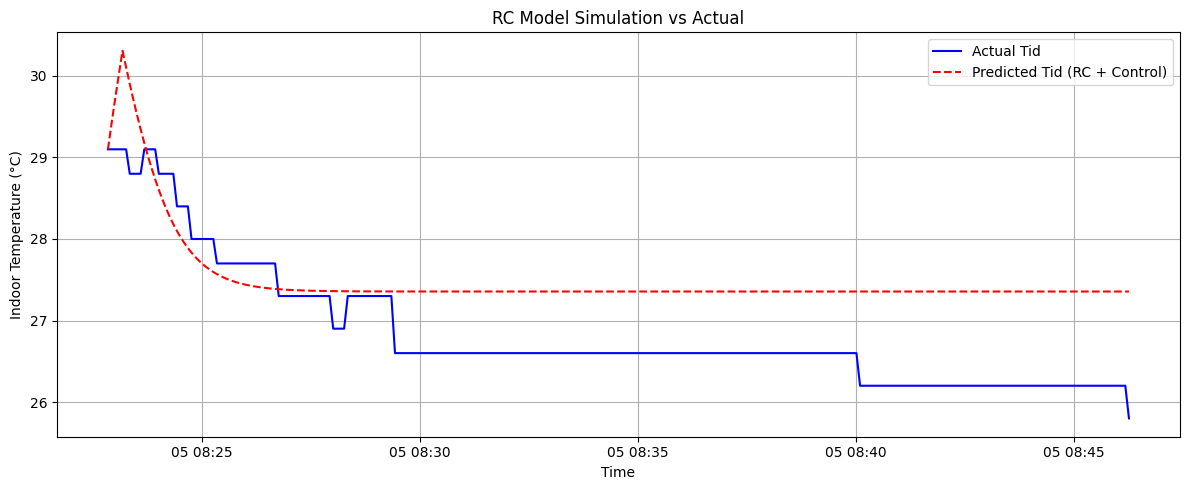

In [362]:
# CSV 파일 경로를 여기에 입력하세요:
csv_path = "/home/deok/Desktop/LG_exp/target_segments_auto2/segment_2024-07-05_08-22_to_2024-07-05_08-46.csv"  # 예시

# 회귀 결과로 얻은 계수 입력
alpha_1 = 0.0324
alpha_2 = 0.0000
alpha_0 = 3.2488

# 시뮬레이션 수행
df_simulated = simulate_rc_model(csv_path, alpha_0, alpha_1, alpha_2)

# 결과 시각화
plot_simulation_result(df_simulated)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -------------------------
# 1. 하이퍼파라미터
# -------------------------
tau = 7806.44  # seconds
dt = 5         # seconds (샘플 간격)

# -------------------------
# 2. CSV 로더
# -------------------------
def load_all_segments(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in files:
        df = pd.read_csv(os.path.join(folder_path, file), parse_dates=['DateTime'])
        if all(col in df.columns for col in ['Tid', 'Tcon', 'Frun', 'Tod']):
            dfs.append(df)
    return dfs

# -------------------------
# 3. 회귀 데이터셋 생성
# -------------------------
def extract_regression_dataset(dfs):
    U_list, Y_dot_list, ΔT_ac_trajectory = [], [], []

    for df in dfs:
        df = df[['DateTime', 'Tid', 'Tcon', 'Frun', 'Tod']].copy()
        df = df.dropna().reset_index(drop=True)

        df['t_sec'] = (df['DateTime'] - df['DateTime'].iloc[0]).dt.total_seconds()
        df['dt'] = df['t_sec'].diff().fillna(5)  # 🔧 추가된 줄

        df['T_inf'] = 0.351 * df['Tod'] + 17.612

        T0 = df['Tid'].iloc[0]
        df['Tid_pred_no_ac'] = df['T_inf'] + (T0 - df['T_inf']) * np.exp(-df['t_sec'] / tau)

        df['Delta_T_ac'] = df['Tid_pred_no_ac'] - df['Tid']
        df['Delta_T_ac_dot'] = (df['Delta_T_ac'].shift(-1) - df['Delta_T_ac']) / df['dt']
        df['Delta_T_ac_dot'] = df['Delta_T_ac_dot'].fillna(0)

        for t in range(len(df) - 1):
            u1 = df.loc[t, 'Tid'] - df.loc[t, 'Tcon']
            u2 = df.loc[t, 'Frun']
            u3 = 1  # bias
            ΔT_dot = df.loc[t, 'Delta_T_ac_dot']

            U_list.append([u1, u2, u3])
            Y_dot_list.append(ΔT_dot)

        ΔT_ac_trajectory.append(df['Delta_T_ac'].values)

    return np.array(U_list), np.array(Y_dot_list), ΔT_ac_trajectory
# -------------------------
# 4. 회귀 학습 및 Euler 적분 예측
# -------------------------
def train_and_simulate(U, Y_dot, ΔT_ac_trajectory, plot=True):
    log_Y_dot = np.log(Y_dot + 1e-6)
    U_r = np.log(U)*U
    reg = LinearRegression()
    reg.fit(U_r, log_Y_dot)

    Y_dot_pred = reg.predict(U)
    rmse = np.sqrt(mean_squared_error(Y_dot, Y_dot_pred))
    print(f"[INFO] 회귀 계수 (alpha_1, alpha_2, bias): {reg.coef_}")
    print(f"[INFO] 절편 (alpha_0): {reg.intercept_}")
    print(f"[INFO] RMSE (ΔT_dot): {rmse:.4f}")

    # -------------------------
    # Euler 방법으로 ΔT_ac 재구성
    # -------------------------
    ΔT_reconstructed = []
    idx = 0
    for ΔT_series in ΔT_ac_trajectory:
        reconstructed = [ΔT_series[0]]
        for _ in range(len(ΔT_series) - 1):
            ΔT_dot = Y_dot_pred[idx]
            ΔT_next = reconstructed[-1] + dt * ΔT_dot
            reconstructed.append(ΔT_next)
            idx += 1
        ΔT_reconstructed.append(reconstructed)

    # -------------------------
    # 시각화
    # -------------------------
    if plot:
        for i in range(len(ΔT_ac_trajectory)):
            actual = ΔT_ac_trajectory[i]
            pred = ΔT_reconstructed[i]
            plt.figure(figsize=(10, 4))
            plt.plot(actual, label='Actual ΔT_ac', color='blue')
            plt.plot(pred, label='Predicted ΔT_ac (Euler Integrated)', color='red', linestyle='--')
            plt.xlabel('Sample Index')
            plt.ylabel('ΔT_ac (°C)')
            plt.title(f'Segment {i+1}: Actual vs Predicted ΔT_ac')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return reg


[INFO] 회귀 계수 (alpha_1, alpha_2, bias): [0.00345458 0.         0.        ]
[INFO] 절편 (alpha_0): -0.00250257398139832
[INFO] RMSE (ΔT_dot): 0.0164


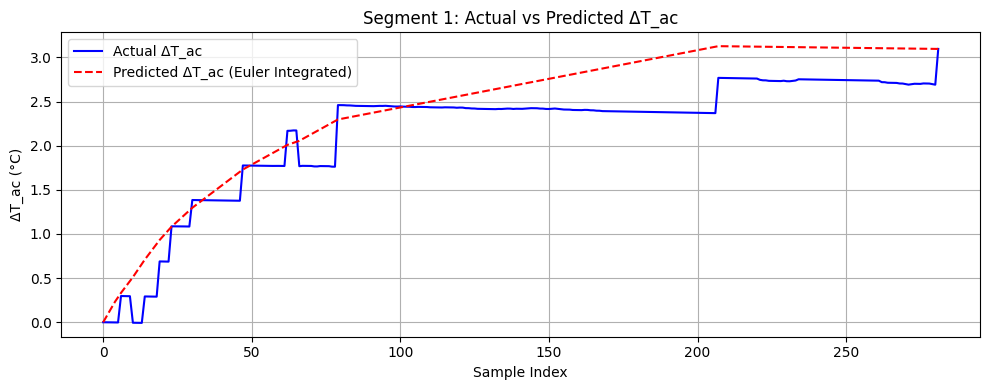

In [310]:
folder_path = '/home/deok/Desktop/LG_exp/target_segments_auto2'  # CSV 경로

dfs = load_all_segments(folder_path)
U, Y_dot, ΔT_ac_all = extract_regression_dataset(dfs)
reg = train_and_simulate(U, Y_dot, ΔT_ac_all)

In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_rc_model_euler(csv_path, alpha_0, alpha_1, alpha_2, tau=7806.44):
    # CSV 로드 및 시간 정렬
    df = pd.read_csv(csv_path, parse_dates=['DateTime'])
    df = df.sort_values('DateTime').reset_index(drop=True)

    # 시간 간격 계산
    df['t_sec'] = (df['DateTime'] - df['DateTime'].iloc[0]).dt.total_seconds()
    df['dt'] = df['t_sec'].diff().fillna(5)  # 첫 샘플은 5초

    # T_inf 계산
    df['T_inf'] = 0.351 * df['Tod'] + 17.612

    # 초기 온도 설정
    T_pred = [df.loc[0, 'Tid']]

    # Euler 적분
    for i in range(1, len(df)):
        Tid = T_pred[-1]
        Tinf = df.loc[i - 1, 'T_inf']
        dt = df.loc[i, 'dt']
        Tcon = df.loc[i - 1, 'Tcon']
        Frun = df.loc[i - 1, 'Frun']

        # 제어 효과 항
        control = alpha_1 * (Tid - Tcon) + alpha_2 * Frun + alpha_0

        # 미분 항 계산
        dT_dt = (Tinf - Tid) / tau - control

        # Euler 방법으로 다음 온도 계산
        T_next = Tid + dt * dT_dt
        T_pred.append(T_next)

    df['Tid_pred'] = T_pred
    return df

def plot_simulation_result(df):
    plt.figure(figsize=(12, 5))
    plt.plot(df['DateTime'], df['Tid'], label='Actual Tid', color='blue')
    plt.plot(df['DateTime'], df['Tid_pred'], label='Predicted Tid (Euler RC + Control)', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Indoor Temperature (°C)')
    plt.title('RC + Control Simulation (Euler) vs Actual')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


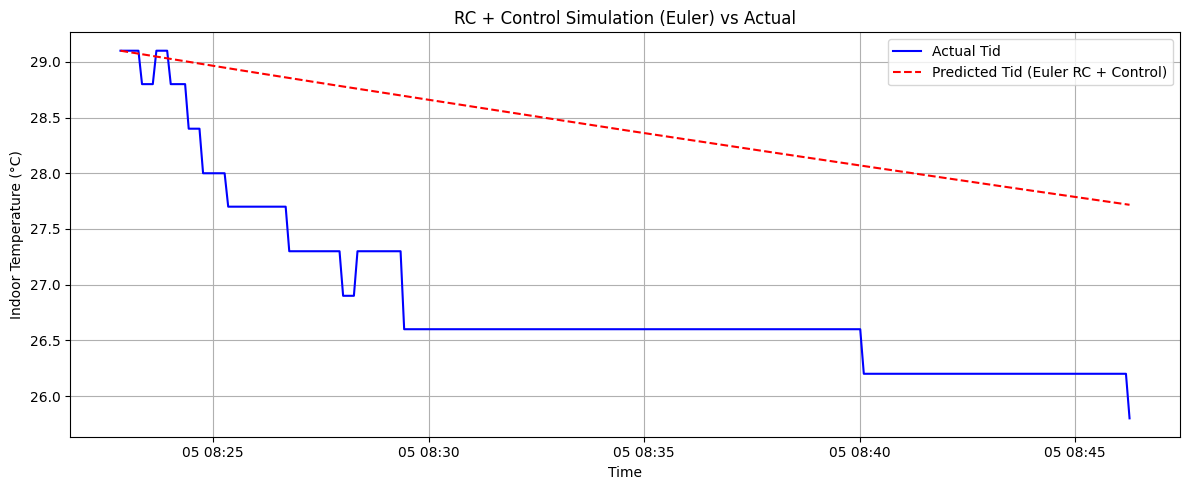

In [312]:
csv_path = '/home/deok/Desktop/LG_exp/target_segments_auto2/segment_2024-07-05_08-22_to_2024-07-05_08-46.csv'
alpha_0 = 0.00345
alpha_1 = 0.0
alpha_2 = -0.0025

df_simulated = simulate_rc_model_euler(csv_path, alpha_0, alpha_1, alpha_2)
plot_simulation_result(df_simulated)